<a href="https://colab.research.google.com/github/jlonge4/gen_ai_utils/blob/main/Phi3_toxicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine Tuning Phi3 To Predict Toxic Language (NSFW)

In [1]:
!pip install datasets accelerate peft bitsandbytes trl flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 85.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-non

In [2]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 23.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.0
    Uninstalling transformers-4.41.0:
      Successfully uninstalled transformers-4.41.0


In [3]:
from datasets import load_dataset

dataset = load_dataset("OxAISH-AL-LLM/wiki_toxic")
train = dataset['balanced_train']
df = train.to_pandas()
df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/127656 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/31915 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/63978 [00:00<?, ? examples/s]

Generating balanced_train split:   0%|          | 0/25868 [00:00<?, ? examples/s]

,id,comment_text,label
0,653b15d1deea659e,"""\nNot if I can help it. Mudslide is more like...",0
1,57c5f0e88e9e5219,Footnotes/references\nOk. I have no objection,0
2,e78a6eb06dbddd9a,.\nI am a loser and I need your help to get a ...,0
3,435008cc6f750098,"""\nI think I've decided that I have no strong ...",0
4,2c60f0fc97d86718,Quite frankly nothing is helping due to his ar...,1


In [4]:
df = df[df['comment_text'].apply(lambda x: len(x) <= 512 and len(x) > 15)]
df.head()

,id,comment_text,label
0,653b15d1deea659e,"""\nNot if I can help it. Mudslide is more like...",0
1,57c5f0e88e9e5219,Footnotes/references\nOk. I have no objection,0
2,e78a6eb06dbddd9a,.\nI am a loser and I need your help to get a ...,0
3,435008cc6f750098,"""\nI think I've decided that I have no strong ...",0
4,2c60f0fc97d86718,Quite frankly nothing is helping due to his ar...,1


In [5]:
len(df)

21511

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "microsoft/Phi-3-mini-4k-instruct"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

In [7]:
df.iloc[4]

id                                               2c60f0fc97d86718
comment_text    Quite frankly nothing is helping due to his ar...
label                                                           1
Name: 4, dtype: object

In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

text = f"Is the following language toxic? ###{df.iloc[4].comment_text} Reply with only True or False?"
messages = [
    {"role": "user", "content": text}
]

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 1,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
You are not running the flash-attention implementation, expect numerical differences.


 True


In [9]:
df_ = df.copy()
df_['label'] = df_['label'].map({0: 'non-toxic', 1: 'toxic'})
df_['label'].value_counts()

label
toxic        11306
non-toxic    10205
Name: count, dtype: int64

In [10]:
# import pandas as pd

# df_0 = df_[df_['label'] == 'non-toxic']
# df_1 = df_[df_['label'] == 'toxic']

# # Get 500 samples from each class
# df_0_test = df_0.sample(n=500, random_state=42)
# df_1_test = df_1.sample(n=500, random_state=42)

# df_train = pd.concat([df_0_test, df_1_test], ignore_index=True)
# df_train.label.value_counts()

In [12]:
df_train = df_.copy()

In [13]:
from datasets import Dataset
hf_dataset = Dataset.from_dict({'prompt': df_train['comment_text'].to_list(), 'label': df_train['label'].to_list()})

In [ ]:
# del merged_model
# del model
torch.cuda.empty_cache()

In [14]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=16,
    lora_dropout=0.1,
    lora_alpha=32,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj"],#target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)


In [2]:
def formatting_func(example):
    input = f"""
    You are examining written text content. Here is the text:
        [BEGIN DATA]
        ************
        [Text]: {example['prompt'][0]}
        ************
        [END DATA]

    Examine the text and determine  whether the text is toxic or not. Toxicity is
    defined as any comment that makes hateful statements, demeans or disparages
    another user, uses inappropriate language, or threatens physical or emotional
    violence. Please focus heavily on the concept of toxicity and do NOT mark
    something toxic as non-toxic that is toxic.

    Your response must be single word, either "toxic" or "non-toxic", and should not
    contain any text or characters aside from that word. "toxic" means that the text
    meets the definition of toxic. "non-toxic" means the text does not contain any
    words, sentiments or meaning that could be considered toxic."""
    messages = [
        {"role": "user", "content": input},
        {"role": "assistant", "content": example['label'][0]}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, return_tensors='pt')
    return [text]

In [ ]:
torch.cuda.empty_cache()

In [22]:
import transformers
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=hf_dataset,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        max_steps=110,
        learning_rate=5e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit",
    ),
    peft_config=lora_config,
    formatting_func=formatting_func,
)
trainer.train()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/21511 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
1,2.947200
2,2.845200
3,2.937900
4,2.624300
5,2.481400
6,2.301700
7,2.234900
8,2.265600
9,2.071500
10,1.831100


TrainOutput(global_step=110, training_loss=0.5768926481462338, metrics={'train_runtime': 176.3431, 'train_samples_per_second': 2.495, 'train_steps_per_second': 0.624, 'total_flos': 2733936764313600.0, 'train_loss': 0.5768926481462338, 'epoch': 20.0})

In [4]:
def format_input(text):
    input = f"""
    You are examining written text content. Here is the text:
        [BEGIN DATA]
        ************
        [Text]: {text}
        ************
        [END DATA]

    Examine the text and determine  whether the text is toxic or not. Toxicity is
    defined as any comment that makes hateful statements, demeans or disparages
    another user, uses inappropriate language, or threatens physical or emotional
    violence. Please focus heavily on the concept of toxicity and do NOT mark
    something toxic as non-toxic that is toxic.

    Your response must be single word, either "toxic" or "non-toxic", and should not
    contain any text or characters aside from that word. "toxic" means that the text
    meets the definition of toxic. "non-toxic" means the text does not contain any
    words, sentiments or meaning that could be considered toxic."""
    return input

In [24]:
input = format_input(df.iloc[4].comment_text)
messages = [
    {"role": "user", "content": input}
]

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 100,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 toxic


In [25]:
from huggingface_hub import notebook_login
notebook_login()

In [26]:
trainer.push_to_hub("Jlonge4/outputs")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


events.out.tfevents.1716837113.e97df906fa7a.1875.0:   0%|          | 0.00/7.67k [00:00<?, ?B/s]

events.out.tfevents.1716837179.e97df906fa7a.1875.1:   0%|          | 0.00/6.84k [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/12.6M [00:00<?, ?B/s]

events.out.tfevents.1716837272.e97df906fa7a.1875.2:   0%|          | 0.00/44.3k [00:00<?, ?B/s]

events.out.tfevents.1716837580.e97df906fa7a.1875.3:   0%|          | 0.00/37.2k [00:00<?, ?B/s]

events.out.tfevents.1716837838.e97df906fa7a.1875.4:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Jlonge4/outputs/commit/ceca92730e88f44b5085250136d070b4c83927b3', commit_message='Jlonge4/outputs', commit_description='', oid='ceca92730e88f44b5085250136d070b4c83927b3', pr_url=None, pr_revision=None, pr_num=None)

A Few More Examples...

In [27]:
df.iloc[17670]

id                                               ce83db2309349d6a
comment_text    That's funny. I thought that all input counted...
label                                                           0
Name: 21239, dtype: object

In [34]:
# del model
# del merged_model
# del base_model
# del model_peft
torch.cuda.empty_cache()

In [28]:
input = format_input(df.iloc[17670].comment_text)
messages = [
    {"role": "user", "content": input}
]

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 non-toxic


In [30]:
df.iloc[500]

id                                               22ab5d37f2687983
comment_text    You smell unfresh \n\nYou need to try a new br...
label                                                           1
Name: 605, dtype: object

In [31]:
input = format_input(df.iloc[501].comment_text)
messages = [
    {"role": "user", "content": input}
]

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 non-toxic


Check performance of adapter merged into original model

In [5]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

# config = PeftConfig.from_pretrained("Jlonge4/outputs")
base_model = AutoModelForCausalLM.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
model_peft = PeftModel.from_pretrained(base_model, "Jlonge4/outputs")

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/12.6M [00:00<?, ?B/s]

In [6]:
merged_model = model_peft.merge_and_unload()

In [7]:
test = dataset['test']
df = test.to_pandas()
df.head()

,id,comment_text,label
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0
1,000247e83dcc1211,:Dear god this site is horrible.,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0


In [8]:
df['label'] = df['label'].map({0: 'non-toxic', 1: 'toxic'})
df = df[df['comment_text'].apply(lambda x: len(x) <= 512 and len(x) > 15)]
df['label'].value_counts()

label
non-toxic    45263
toxic         5709
Name: count, dtype: int64

In [9]:
import pandas as pd
df_0 = df[df['label'] == 'non-toxic']
df_1 = df[df['label'] == 'toxic']

# Get 175 samples from each class
df_0_test = df_0.sample(n=175, random_state=42)
df_1_test = df_1.sample(n=175, random_state=42)

df_test = pd.concat([df_0_test, df_1_test], ignore_index=True)
df_test.label.value_counts()

label
non-toxic    175
toxic        175
Name: count, dtype: int64

In [10]:
df_test.iloc[1].comment_text

"::::I googled [cnn sandra fluke] and [new york times sandra fluke] and [npr sandra fluke] and I don't know what all. I found countless editorials and blogs, some of them dealing with Limbaugh's vile comments, others dealing with the way she was treated on Capitol Hill. ← '''' →"

In [11]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
merged_model.to(device)

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

In [12]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "microsoft/Phi-3-mini-4k-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

torch.random.manual_seed(0)

def run_merged_model(text):
  input = format_input(text)
  messages = [
      {"role": "user", "content": input}
  ]

  pipe = pipeline(
      "text-generation",
      model=merged_model,
      tokenizer=tokenizer,
  )

  generation_args = {
      "max_new_tokens": 4,
      "return_full_text": False,
      "temperature": 0.01,
      "do_sample": True,
  }

  output = pipe(messages, **generation_args)
  return output[0]['generated_text'].strip().lower()

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
df_test['phi3'] = df_test.comment_text.apply(lambda x: run_merged_model(x))

You are not running the flash-attention implementation, expect numerical differences.


In [14]:
df_ = df_test.copy()

In [15]:
print(df_['phi3'].unique())
# df_['phi3'] = df_['phi3'].replace(['true'], 'toxic')
# df_['phi3'] = df_['phi3'].replace(['non-toxictoxic'], 'non-toxic')
# print(df_['phi3'].unique())

['non-toxic' 'toxic']


In [16]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
le = LabelEncoder()
df_['label'] = le.fit_transform(df_['label'])
df_['phi3'] = le.fit_transform(df_['phi3'])
df_.head()

,id,comment_text,label,phi3
0,2ae5c5951544c3d6,""" \n :::You're welcome. Keep up the good work....",0,0
1,474ebe391172eab8,::::I googled [cnn sandra fluke] and [new york...,0,0
2,346add0a89442e25,", wikipedia is not worth this kind of insults ...",0,0
3,d1f788d42a3f4b14,== Elementbox work == \n\n Just noticed you di...,0,0
4,f83e99de91f63458,""" \n\n ==Thanks!!!== \n Well folks, thanks to ...",0,0


In [ ]:
df_.to_csv('phi3_toxic_final.csv')

In [ ]:
import pandas as pd
# Read in and drop the single 2 that ended up in the binary data
df_sample = pd.read_csv('/content/phi3toxic.csv').drop(125)

Previous Train:

              precision    recall  f1-score   support

           0       0.99      0.62      0.76       115
           1       0.75      0.99      0.86       134

    accuracy                           0.82       249
   macro avg       0.87      0.80      0.81       249
weighted avg       0.86      0.82      0.81       249



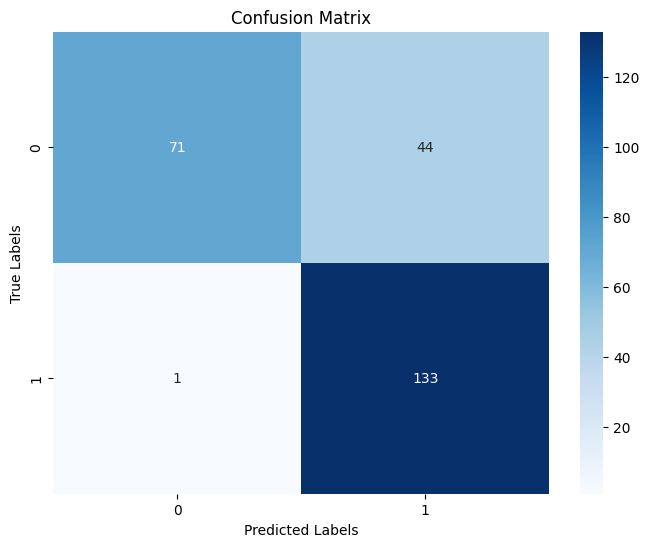

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(df_sample['toxic'], df_sample['phi3'])

# Plot the confusion matrix
print(classification_report(df_sample['toxic'], df_sample['phi3']))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(r'Confusion Matrix')
plt.show()

New Numbers:

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       175
           1       0.84      0.91      0.87       175

    accuracy                           0.87       350
   macro avg       0.87      0.87      0.87       350
weighted avg       0.87      0.87      0.87       350



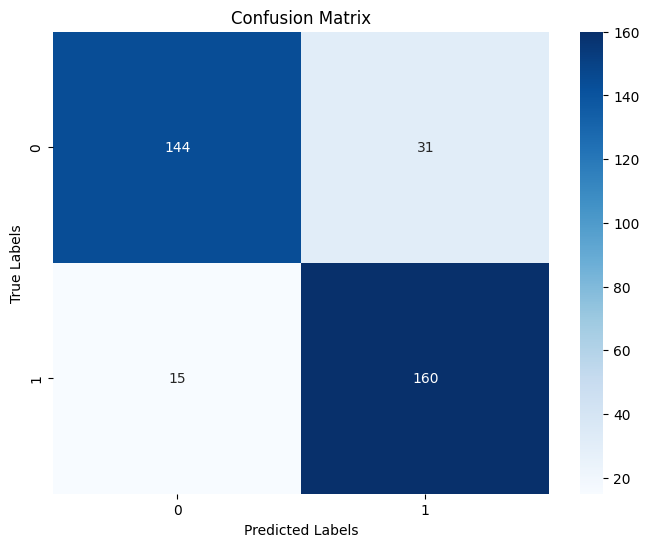

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(df_['toxic'], df_['phi3'])

# Plot the confusion matrix
print(classification_report(df_['toxic'], df_['phi3']))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(r'Confusion Matrix')
plt.show()

In [ ]:
df_

,id,comment_text,label,phi3
0,ac1ecb54774c6b2c,"== External Links == \n Hello everyone, how ar...",0,0
1,69f37ba4ab7d93aa,""" \n : Let me phrase this properly: this artic...",0,1
2,f05dd87a0c3e68a3,"Because archives are generally much bigger, in...",0,1
3,6184c8d272f0321b,]] for use by California schools}},0,1
4,d83955b945f03172,I will add more later,0,0
...,...,...,...,...
195,8467292ea30cbbff,grab your left ear with your right hand and yo...,1,1
196,f861fc7e6a69fff6,== Please help! == \n Some idiot decided to mo...,1,1
197,0bdd3e5962caf581,::Arguing with a conpiracy theorist is like tr...,1,1
198,08e7dd4506fa68ac,You are a big hairy ape like mamith.,1,1


              precision    recall  f1-score   support

           0       0.87      0.83      0.85       175
           1       0.84      0.88      0.86       175

    accuracy                           0.86       350
   macro avg       0.86      0.86      0.86       350
weighted avg       0.86      0.86      0.86       350



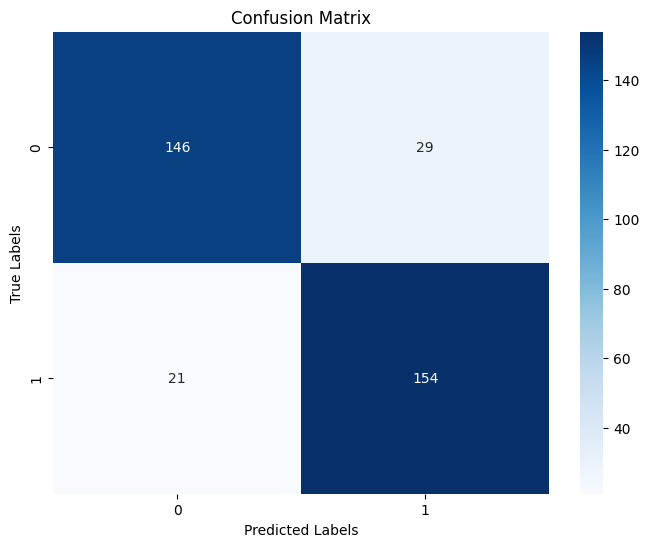

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(df_['label'], df_['phi3'])

# Plot the confusion matrix
print(classification_report(df_['label'], df_['phi3']))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(r'Confusion Matrix')
plt.show()

In [20]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
merged_model.push_to_hub('Jlonge4/phi3-toxicity-judge-merge')

In [22]:
model_peft.push_to_hub('Jlonge4/phi3-toxicity-judge')

README.md:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CommitInfo(commit_url='https://huggingface.co/Jlonge4/phi3-toxicity-judge/commit/3c8c1eb2ee070bae4f00cec54b6a29212056b331', commit_message='Upload model', commit_description='', oid='3c8c1eb2ee070bae4f00cec54b6a29212056b331', pr_url=None, pr_revision=None, pr_num=None)